# Λήψεις Τεσσάρων Πλευρών
Στο αρχείο multiple_views.yml έχουμε ορίσει από ποιες εικόνες ανιχνεύουμε επιφάνεια λιπώδους ιστού.

Δομή του αρχείου yaml: 
```
samples: [0h, 24h, 48h, 72h, 96h, 120h, 144h, 192h, 240h]
mouse_id: [mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]
mouse_angle: [brosta, aristera, pisw, deksia]
mouse_1: 

```

| Γωνία Λήψης | Μπροστά               | Αριστερά              | Πίσω                   | Δεξιά                  |
| ----------- | --------------------- | --------------------- | ---------------------- | ---------------------- |
| `.jpg`      | `[IR_2060.csv, ...]`  | `[IR_2096.csv, ...]`  | `[IR_2088.csv, ....]`  | `[IR_2080.csv, ....]`  |
| `.csv`      | `[CSV_2060.csv, ...]` | `[CSV_2096.csv, ...]` | `[CSV_2088.csv, ....]` | `[CSV_2080.csv, ....]` |


![εικόνα](img/cube_net.png)

### Διαθέσιμα `csv` αρχεία και ελλειπή δεδομένα
#### Αναντιστοιχία των Θερμικών Εικόνων με τα Δεδομένα του Αισθητήρα
|      | mouse_1              | mouse_2              | mouse_3              | mouse_4              | mouse_5              |
| ---- | -------------------- | -------------------- | -------------------- | -------------------- | -------------------- |
| 0h   | ('✔', '✔', '✔', '✔') | ('✔', '✔', '✔', '✔') | ('✔', '✔', '✔', '✔') | ('✔', '✔', '✔', '✔') | ('✔', '✔', '✔', '✔') |
| 24h  | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '✔', '✔', '✔') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') |
| 48h  | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '✔', '✔', '❌') | ('✔', '❌', '✔', '❌') |
| 72h  | ('✔', '✔', '✔', '✔') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') |
| 96h  | ('✔', '❌', '✔', '❌') | ('✔', '✔', '✔', '✔') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') |
| 120h | ('✔', '✔', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '✔') |
| 144h | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') |
| 192h | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') |
| 240h | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') | ('✔', '❌', '✔', '❌') |

In [1]:
import os
import sys
import yaml
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from celluloid import Camera
from tqdm import tqdm
from IPython.display import HTML # to show the animation in Jupyter

from skimage.io import imread
from skimage.exposure import histogram
from skimage.filters.rank import entropy
from skimage.morphology import disk, square, skeletonize, thin, dilation
from skimage.util import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from skimage.measure import label, regionprops, regionprops_table

from sklearn import cluster, preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from src.data import data_utils
from src.features import mouse_detection, img_to_vectors
from src.visualization import rect_roi, mask_orientation

# Εισαγωγή του αρχείου yaml
with open(module_path + '/data/multiple_views.yml') as file:
    experiment = yaml.load(file, Loader=yaml.FullLoader)
# access: experiment['samples'], experiment['mouse_id']
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.arguments)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

src.data.data_utils


### Εισαγωγή Δεδομένων και Επεξεργασία

In [2]:
# Πρόσβαση στα δεδομένα του αρχείου
# Κατασκευή των global path για τα αρχεία του πειράματος
infrared_items, csv_items = [], []
identifiers = []
for i, hour in enumerate(experiment['samples']):
    for mouse_name in experiment['mouse_id']:
        for mouse_angle in experiment['mouse_angle']:
            jpg_file = experiment[mouse_name][mouse_angle]['jpg'][i]
            infrared_items.append(f'{module_path}/data/raw/{hour}/{mouse_name}/{jpg_file}')
            identifiers.append((mouse_angle, mouse_name, hour))
            csv_file = experiment[mouse_name][mouse_angle]['csv'][i]
            csv_items.append(f'{module_path}/data/raw/{hour}/{mouse_name}/{csv_file}')
            identifiers.append({'mouse_name':mouse_name, 'mouse_angle':mouse_angle, 'hour':hour})

# Εισαγωγή των δεδομένων με βάση τα path και προεπεξεργασία
infrared_images = [data_utils.IR_fixer(fpath=item) for item in infrared_items]

markerBack, markerBody = 70, 150
object_images, object_masks, initial_masks, mouse_locations = mouse_detection.mouse_detection(infrared_images, markerBack, markerBody)

In [6]:
print(object_images[0].nbytes)
for i, (object_images, object_mask, initial_mask) in emumerate(zip(object_images, object_masks, initial_masks)):
    sss

161448


### Ενώ υπάρχουν 4 θερμικές λήψεις για κάθε δείγμα, δεν υπάρχουν όλα τα αρχεία θερμοκρασιών
#### Αυτό δεν είναι πρόβλημα για την τρισδιάστατη ανακατασκευή, καθώς θα χρησιμοποιηθούν μόνο οι jpg εικόνες

In [3]:
csv_images = [] # will store (240, 160) arrays
for item in csv_items:
    if os.path.exists(item):
        csv_images.append(data_utils.CSV_fixer(item))
    else:
        csv_images.append(np.ones_like(infrared_images[0]))
    
csv_thermals = [mask[mouse_location] * csv[mouse_location] for (mask, csv, mouse_location) in zip(initial_masks, csv_images, mouse_locations)]

### Αντικατάσταση των υπολοιπόμενων με τις τιμές των μασκών τους

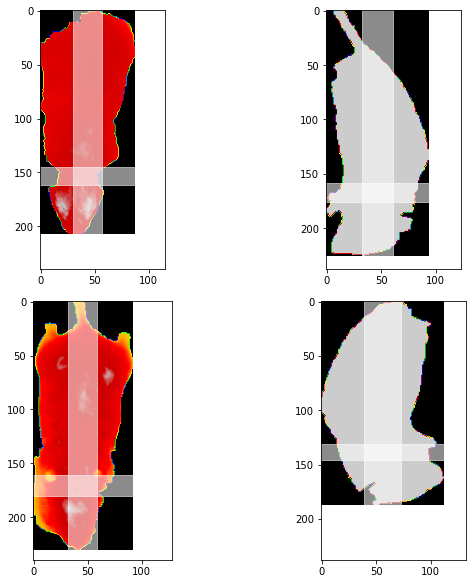

In [7]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
for i in range(0, len(csv_thermals), 4):
    ax0.imshow(X=csv_thermals[i], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)

    ax1.imshow(X=csv_thermals[i + 1], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 1])
    ax1.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax1.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax2.imshow(X=csv_thermals[i + 2], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 2])
    ax2.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax2.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax3.imshow(X=csv_thermals[i + 3], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 3])
    ax3.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax3.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Οι τέσσερεις πλευρές κάθε δείγματος θερμικής εικόνας

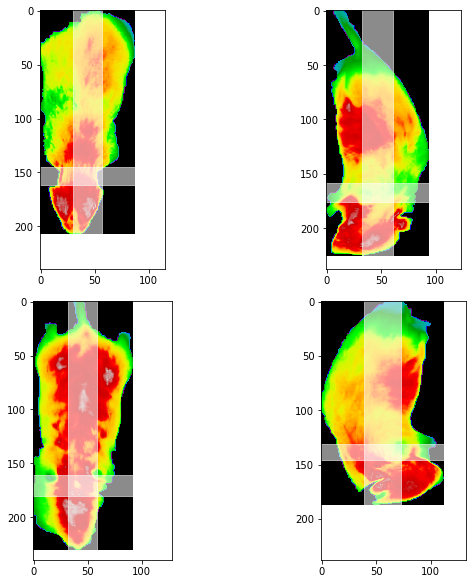

In [6]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
for i in range(0, len(object_images), 4):
    ax0.imshow(X=object_images[i], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)

    ax1.imshow(X=object_images[i + 1], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 1])
    ax1.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax1.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax2.imshow(X=object_images[i + 2], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 2])
    ax2.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax2.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax3.imshow(X=object_images[i + 3], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 3])
    ax3.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax3.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
recten = HTML(animation.to_html5_video()) # displaying the animation

## Ιδιότητες Μάσκας και Θερμικής Εικόνας
### Διαστάσεις και Κατεύθυνση Μάσκας

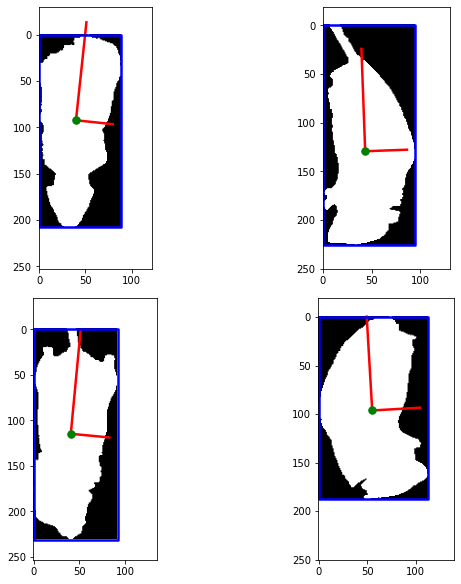

In [8]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
for counter, i in enumerate(range(0, len(object_images), 4)):    
    regions = regionprops(object_masks[i].astype(np.uint8))
    ax0.imshow(object_masks[i], cmap=plt.cm.gray)
    x0, x1, x2, y0, y1, y2, bx, by = mask_orientation.mask_orientation(regions)
    ax0.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax0.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax0.plot(x0, y0, '.g', markersize=15)
    ax0.plot(bx, by, '-b', linewidth=2.5)
    
    regions = regionprops(object_masks[i + 1].astype(np.uint8))
    ax1.imshow(object_masks[i + 1], cmap=plt.cm.gray)
    x0, x1, x2, y0, y1, y2, bx, by = mask_orientation.mask_orientation(regions)
    ax1.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax1.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax1.plot(x0, y0, '.g', markersize=15)
    ax1.plot(bx, by, '-b', linewidth=2.5)
        
    regions = regionprops(object_masks[i + 2].astype(np.uint8))
    ax2.imshow(object_masks[i + 2], cmap=plt.cm.gray)
    x0, x1, x2, y0, y1, y2, bx, by = mask_orientation.mask_orientation(regions)
    ax2.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax2.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax2.plot(x0, y0, '.g', markersize=15)
    ax2.plot(bx, by, '-b', linewidth=2.5)
        
    regions = regionprops(object_masks[i + 3].astype(np.uint8))
    ax3.imshow(object_masks[i + 3], cmap=plt.cm.gray)
    x0, x1, x2, y0, y1, y2, bx, by = mask_orientation.mask_orientation(regions)
    ax3.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax3.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax3.plot(x0, y0, '.g', markersize=15)
    ax3.plot(bx, by, '-b', linewidth=2.5)
        
    camera.snap()

animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Εξαγωγή Γεωμετρικών Χαρακτηριστικών των Μασκών

In [4]:
### feature: pad images centered to centroids
all_properties = {} # len 45
for counter, i in enumerate(range(0, len(object_images), 4)):
    mask_list = [object_masks[i], object_masks[i + 1], object_masks[i + 2], object_masks[i + 3]]
    mask_regionprops = [regionprops(mask.astype(np.uint8)) for mask in mask_list]
    sample_properties = {counter: mask_regionprops}
    all_properties = {**all_properties, **sample_properties}

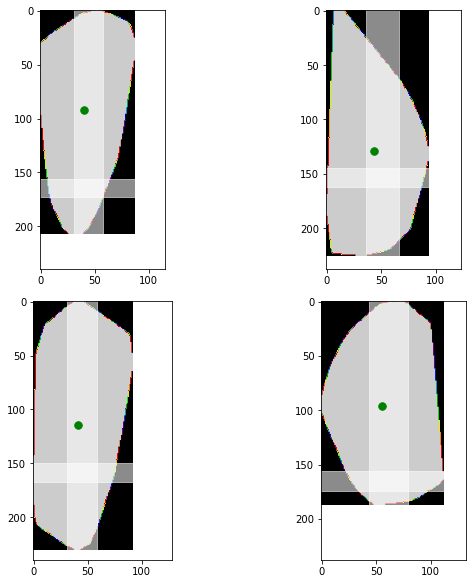

In [16]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
#sides = {brosta: 0, deskia: 1, pisw: 2, aristera: 3}


for i in range(0, 45):
    #print(all_properties[i][0])
    ax0.imshow(X=all_properties[i][0][0].convex_image, cmap=plt.cm.nipy_spectral)
    y0, x0 = all_properties[i][0][0].centroid
    ax0.plot(x0, y0, '.g', markersize=15)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax1.imshow(X=all_properties[i][1][0].convex_image, cmap=plt.cm.nipy_spectral)
    y0, x0 = all_properties[i][1][0].centroid
    ax1.plot(x0, y0, '.g', markersize=15)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 1])
    ax1.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax1.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax2.imshow(X=all_properties[i][2][0].convex_image, cmap=plt.cm.nipy_spectral)
    y0, x0 = all_properties[i][2][0].centroid
    ax2.plot(x0, y0, '.g', markersize=15)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 2])
    ax2.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax2.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax3.imshow(X=all_properties[i][3][0].convex_image, cmap=plt.cm.nipy_spectral)
    y0, x0 = all_properties[i][3][0].centroid
    ax3.plot(x0, y0, '.g', markersize=15)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 3])
    ax3.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax3.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

In [18]:
def add_centered_images(images, centroids, shapes):
    centered_image = np.zeros(shape=(400, 400))
    centered_image 
    print(f'image shape before {centered_image.shape}')
    centered_image = np.pad(centered_image, pad_width=(400, 400))
    print(f'image shape after {centered_image.shape}')
    return centered_image

shape = np.shape(an_array)
pad_widthadded_array = np.zeros((3, 3))
padded_array[:shape[0],:shape[1]] = an_array


In [17]:
print(shapes)
print(centroids)

[(218, 95), (184, 118), (208, 100), (202, 100)]
[(99.26389690325063, 48.31358594601526), (92.44462668473223, 62.4153890037795), (92.52671862930974, 44.62277929920651), (103.63411781903231, 49.04027189007455)]


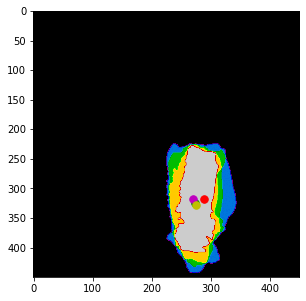

In [41]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
# camera = Camera(fig)
# sides = {'brosta': 0, 'deskia': 1, 'pisw': 2, 'aristera': 3}
# print(all_properties[i][0])

images = [all_properties[10][0][0].image,
          all_properties[10][1][0].image,
          all_properties[10][2][0].image,
          all_properties[10][3][0].image]
shapes = [all_properties[10][0][0].convex_image.shape,
          all_properties[10][1][0].convex_image.shape,
          all_properties[10][2][0].convex_image.shape,
          all_properties[10][3][0].convex_image.shape]
# animation = camera.animate(interval=1000)
centroids = [all_properties[10][0][0].centroid,
          all_properties[10][1][0].centroid,
          all_properties[10][2][0].centroid,
          all_properties[10][3][0].centroid]


# an_array = np.array([[1, 2], [3, 4]])
# shape = np.shape(an_array)
# padded_array = np.zeros((40, 40))
# padded_array[20:shape[0]+20, 20:20+shape[1]] = an_array

an_array = images[0]
shape = np.shape(an_array)
padded_array = np.zeros((450, 450))
padded_array[225:shape[0]+225, 225:225+shape[1]] = an_array

an_array = images[1]
shape = np.shape(an_array)
#padded_array = np.zeros((500, 500))
padded_array[225:shape[0]+225, 225:225+shape[1]] += an_array

an_array = images[2]
shape = np.shape(an_array)
#padded_array = np.zeros((500, 500))
padded_array[225:shape[0]+225, 225:225+shape[1]] += an_array

an_array = images[3]
shape = np.shape(an_array)
#padded_array = np.zeros((500, 500))
padded_array[225:shape[0]+225, 225:225+shape[1]] += an_array

ax0.imshow(X=padded_array, cmap=plt.cm.nipy_spectral)
y0, x0 = centroids[0]
ax0.plot(x0+225, y0+225, '.g', markersize=15)
y0, x0 = centroids[1]
ax0.plot(x0+225, y0+225, '.r', markersize=15)
y0, x0 = centroids[2]
ax0.plot(x0+225, y0+225, '.m', markersize=15)
y0, x0 = centroids[3]
ax0.plot(x0+225, y0+225, '.y', markersize=15)
# το HTML πρέπει να τρέχει στο jupyter notebook 
# HTML(animation.to_html5_video()) # displaying the animation

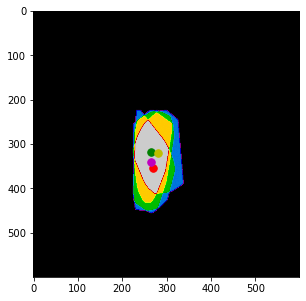

In [45]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])

camera = Camera(fig)
#sides = {brosta: 0, deskia: 1, pisw: 2, aristera: 3}

for i in range(0, 45):
    images = [all_properties[i][0][0].convex_image,
          all_properties[i][1][0].convex_image,
          all_properties[i][2][0].convex_image,
          all_properties[i][3][0].convex_image]
    shapes = [all_properties[i][0][0].convex_image.shape,
              all_properties[i][1][0].convex_image.shape,
              all_properties[i][2][0].convex_image.shape,
              all_properties[i][3][0].convex_image.shape]
    # animation = camera.animate(interval=1000)
    centroids = [all_properties[i][0][0].centroid,
              all_properties[i][1][0].centroid,
              all_properties[i][2][0].centroid,
              all_properties[i][3][0].centroid]


    # an_array = np.array([[1, 2], [3, 4]])
    # shape = np.shape(an_array)
    # padded_array = np.zeros((40, 40))
    # padded_array[20:shape[0]+20, 20:20+shape[1]] = an_array

    an_array = images[0]
    shape = np.shape(an_array)
    padded_array = np.zeros((600, 600))
    padded_array[225:shape[0]+225, 225:225+shape[1]] = an_array

    an_array = images[1]
    shape = np.shape(an_array)
    #padded_array = np.zeros((500, 500))
    padded_array[225:shape[0]+225, 225:225+shape[1]] += an_array

    an_array = images[2]
    shape = np.shape(an_array)
    #padded_array = np.zeros((500, 500))
    padded_array[225:shape[0]+225, 225:225+shape[1]] += an_array

    an_array = images[3]
    shape = np.shape(an_array)
    #padded_array = np.zeros((500, 500))
    padded_array[225:shape[0]+225, 225:225+shape[1]] += an_array

    ax0.imshow(X=padded_array, cmap=plt.cm.nipy_spectral)
    y0, x0 = centroids[0]
    ax0.plot(x0+225, y0+225, '.g', markersize=15)
    y0, x0 = centroids[1]
    ax0.plot(x0+225, y0+225, '.r', markersize=15)
    y0, x0 = centroids[2]
    ax0.plot(x0+225, y0+225, '.m', markersize=15)
    y0, x0 = centroids[3]
    ax0.plot(x0+225, y0+225, '.y', markersize=15)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

difference_1 = padded_array.shape[1] - images[0].shape[1]
difference_0 = padded_array.shape[0] - images[0].shape[0]

In [65]:
identifiers = [] # len 180 
for hour in experiment['samples']:
    for mouse_name in experiment['mouse_id']:
        for mouse_angle in experiment['mouse_angle']:
            identifiers.append({'hour':hour, 'mouse_name':mouse_name, 'mouse_angle':mouse_angle})

In [66]:
for i, identifier in enumerate(identifiers):
    identifier['id'] = i

In [ ]:
# len 45 
for counter, i in enumerate(range(0, len(object_images), 4)):
    identifiers[counter] = {**identifiers[counter], 'counter': counter, 'id': i}

In [59]:
identifier = {'hour': '0h', 'mouse_name': 'mouse_4', 'mouse_angle': 'pisw'}

In [61]:
identifier

{'hour': '0h', 'mouse_name': 'mouse_4', 'mouse_angle': 'pisw', 10: 10}